# Comparative Pass Analysis between Aleix Garcia and Kirian Rodriguez in the 2023/2024 Season

In this report, we carry out a detailed analysis of the two central midfielders with the highest number of passes in the Spanish League during the 2023/2024 season: Aleix Garcia and Kirian Rodriguez. Using a combination of passing statistics, heat maps, pass source clusters and statistical tests, we have investigated how each player distributes the ball on the pitch, identifying key patterns and differences in their playing style.

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.stats import gaussian_kde
from statsmodels.stats.proportion import proportions_ztest

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


from mplsoccer import Pitch, VerticalPitch
# disable warnings
import warnings
warnings.filterwarnings('ignore')

## Data loading and preparation

In [2]:
passes = pd.read_csv('passes.csv')
girona_logo = 'girona.png'
las_palmas_logo = 'udlaspalmas.png'

In [3]:
passes.head()

player_name  team_id  home_team_id  team_name     matchday match_name  \
0  Aleix Garcia      384           445  Girona FC  Matchday 35  ALA - GIR   
1  Aleix Garcia      384           445  Girona FC  Matchday 35  ALA - GIR   
2  Aleix Garcia      384           445  Girona FC  Matchday 35  ALA - GIR   
3  Aleix Garcia      384           445  Girona FC  Matchday 35  ALA - GIR   
4  Aleix Garcia      384           445  Girona FC  Matchday 35  ALA - GIR   

            match_date  home_team_score  away_team_score  start_frame  ...  \
0  2024-05-10T21:00:00                2                2       115975  ...   
1  2024-05-10T21:00:00                2                2       110075  ...   
2  2024-05-10T21:00:00                2                2       116925  ...   
3  2024-05-10T21:00:00                2                2       134850  ...   
4  2024-05-10T21:00:00                2                2       136750  ...   

   outcome  long_ball  is_a_cross  free_kick  corner_kick  throw_in  aerial  \
0        0          0           0          1            0         0       1   
1        0          1           0          0            0         0       0   
2        1          1           1          0            1         0       1   
3        1          0           0          0            0         0       0   
4        1          0           0          0            0         0       0   

   switch_of_play  assist  second_assist  
0               0       0              0  
1               0       0              0  
2               0       1              0  
3               0       0              0  
4               0       0              0  

[5 rows x 25 columns]

In [4]:
conditions = (passes['corner_kick'] == 0) & (passes['free_kick'] == 0) & (passes['throw_in'] == 0)
filtered_passes = passes[conditions].drop(columns=['corner_kick', 'free_kick', 'throw_in'])
filtered_passes.head()

player_name  team_id  home_team_id  team_name     matchday match_name  \
1  Aleix Garcia      384           445  Girona FC  Matchday 35  ALA - GIR   
3  Aleix Garcia      384           445  Girona FC  Matchday 35  ALA - GIR   
4  Aleix Garcia      384           445  Girona FC  Matchday 35  ALA - GIR   
6  Aleix Garcia      384           445  Girona FC  Matchday 35  ALA - GIR   
7  Aleix Garcia      384           445  Girona FC  Matchday 35  ALA - GIR   

            match_date  home_team_score  away_team_score  start_frame  ...  \
1  2024-05-10T21:00:00                2                2       110075  ...   
3  2024-05-10T21:00:00                2                2       134850  ...   
4  2024-05-10T21:00:00                2                2       136750  ...   
6  2024-05-10T21:00:00                2                2       122650  ...   
7  2024-05-10T21:00:00                2                2       136325  ...   

   start_y  end_x  end_y  outcome  long_ball  is_a_cross  aerial  \
1     68.0   67.5   13.4        0          1           0       0   
3     73.4   79.2   70.8        1          0           0       0   
4     22.7   35.2    6.8        1          0           0       0   
6     51.0   31.9   43.7        1          0           0       0   
7     48.5   27.7   52.7        1          0           0       0   

   switch_of_play  assist  second_assist  
1               0       0              0  
3               0       0              0  
4               0       0              0  
6               0       0              0  
7               0       0              0  

[5 rows x 22 columns]

## Descriptive Analysis

In [5]:
cols = ['start_x', 'start_y', 'end_x', 'end_y', 'outcome']
filtered_passes.groupby('player_name')[cols].describe().transpose()

player_name    Aleix Garcia  Kirian Rodriguez
start_x count   2675.000000       2932.000000
        mean      47.607850         48.435778
        std       17.569225         16.124977
        min        0.800000          2.800000
        25%       34.200000         35.375000
        50%       46.600000         46.800000
        75%       62.400000         61.700000
        max       97.800000         95.200000
start_y count   2675.000000       2932.000000
        mean      50.760710         56.935846
        std       23.232302         23.132820
        min        1.500000          1.900000
        25%       32.400000         38.000000
        50%       51.900000         60.900000
        75%       69.150000         75.300000
        max       97.700000         99.000000
end_x   count   2675.000000       2932.000000
        mean      51.504636         51.389666
        std       21.167515         19.728360
        min        2.300000          1.400000
        25%       34.600000         35.900000
        50%       53.100000         52.650000
        75%       67.500000         66.100000
        max      100.000000        100.000000
end_y   count   2675.000000       2932.000000
        mean      49.566916         57.581105
        std       29.490355         27.540046
        min        0.000000          0.000000
        25%       23.750000         35.050000
        50%       49.900000         62.300000
        75%       75.800000         81.200000
        max      100.000000        100.000000
outcome count   2675.000000       2932.000000
        mean       0.906168          0.890518
        std        0.291649          0.312296
        min        0.000000          0.000000
        25%        1.000000          1.000000
        50%        1.000000          1.000000
        75%        1.000000          1.000000
        max        1.000000          1.000000

In [6]:
progressive_pass_conditions = [
    (filtered_passes['start_x'] <= 50) & (filtered_passes['end_x'] <= 50) & ((filtered_passes['end_x'] - filtered_passes['start_x']) >= 30),
    (filtered_passes['start_x'] <= 50) & (filtered_passes['end_x'] > 50) & ((filtered_passes['end_x'] - filtered_passes['start_x']) >= 15),
    (filtered_passes['start_x'] > 50) & (filtered_passes['end_x'] > 50) & ((filtered_passes['end_x'] - filtered_passes['start_x']) >= 10)
]
final_third_pass_conditions = [(filtered_passes['end_x'] > 66.6)]

# add new colums setting the conditions
filtered_passes['is_progressive'] = np.select(progressive_pass_conditions, [1, 1, 1], default=0)
filtered_passes['into_final_third'] = np.select(final_third_pass_conditions, [1], default=0)

In [7]:
# Check descriptive statistics for the labeled columns
cols = ['is_a_cross', 'long_ball', 'switch_of_play', 'assist', 'second_assist', 'aerial', 'is_progressive', 'into_final_third','outcome']

# sum of the columns
cont = filtered_passes.groupby('player_name')[cols].sum().reset_index()
cont = cont.rename(columns={'index': 'label'})
# Add total_passes
cont['total_passes'] = filtered_passes.groupby('player_name').size().values
cont['success_prop'] = cont['outcome'] / cont['total_passes']
cont

player_name  is_a_cross  long_ball  switch_of_play  assist  \
0      Aleix Garcia          46        281              74      27   
1  Kirian Rodriguez          15        137               8      37   

   second_assist  aerial  is_progressive  into_final_third  outcome  \
0              1     262             494               710     2424   
1              0     162             410               706     2611   

   total_passes  success_prop  
0          2675      0.906168  
1          2932      0.890518

In [8]:
columns_to_compare = ['is_a_cross', 'long_ball', 'switch_of_play', 'assist', 'second_assist', 'aerial', 'is_progressive', 'into_final_third', 'outcome']

# Filter the data for the two players
aleix_data = filtered_passes[filtered_passes['player_name'] == 'Aleix Garcia']
kirian_data = filtered_passes[filtered_passes['player_name'] == 'Kirian Rodriguez']

# z-test for each variable
for column in columns_to_compare:
    count = cont[column].values
    nobs = cont['total_passes'].values
    z_stat, p_value = proportions_ztest(count, nobs)
    print(f"Variable: {column}, Z-statistic: {z_stat:.2f}, P-value: {p_value:.4f}")

    if p_value < 0.05:
        print('The difference is statistically significant')
    else:
        print('The difference is not statistically significant')

Variable: is_a_cross, Z-statistic: 4.36, P-value: 0.0000
The difference is statistically significant
Variable: long_ball, Z-statistic: 8.30, P-value: 0.0000
The difference is statistically significant
Variable: switch_of_play, Z-statistic: 7.77, P-value: 0.0000
The difference is statistically significant
Variable: assist, Z-statistic: -0.89, P-value: 0.3738
The difference is not statistically significant
Variable: second_assist, Z-statistic: 1.05, P-value: 0.2951
The difference is not statistically significant
Variable: aerial, Z-statistic: 6.04, P-value: 0.0000
The difference is statistically significant
Variable: is_progressive, Z-statistic: 4.56, P-value: 0.0000
The difference is statistically significant
Variable: into_final_third, Z-statistic: 2.12, P-value: 0.0340
The difference is statistically significant
Variable: outcome, Z-statistic: 1.93, P-value: 0.0531
The difference is not statistically significant


### Aleix Garcia:

He made 2,675 passes in total with a success rate of 90.6%.
He stands out for the number of long passes (281) and switches of play (74).
Also notable is the number of progressive passes (494) and passes into the final third (710).

### Kirian Rodriguez:

He made 2,932 passes in total with a success rate of 89.1%.
He has fewer long passes (137) and switches of play (8) compared to Aleix.
Although he has fewer progressive passes (410) and passes into the final third (706), he is quite close to Aleix in the latter.

### Statistical Analysis of Differences

#### Significant Differences:

- Is_a_cross: Aleix has a significantly higher number of crosses than Kirian, with a Z-statistic of 4.36 (p < 0.001).

- Long_ball: Aleix also excels at long passes, with a Z-statistic of 8.30 (p < 0.001), indicating that this is a key aspect of his game.

- Switch_of_play: Aleix makes significantly more switches of play than Kirian (Z-statistic of 7.77, p < 0.001).

- Aerial: The amount of aerial passes is also significantly higher for Aleix (Z-statistic of 6.04, p < 0.001).

- Is_progressive: Aleix has more progressive passes, suggesting a greater contribution to the team's progression (Z-statistic of 4.56, p < 0.001).

- Into_final_third: Aleix also makes more passes into the final third, but the difference is less pronounced (Z-statistic of 2.12, p = 0.034).

#### Non-Significant Differences:

- Assist and Second_assist: There are no significant differences between both players in terms of assists and second_assists, indicating that their direct contribution to goal scoring is comparable.

- Outcome: Although Aleix has a slightly higher success rate, this difference is not statistically significant (Z-statistic of 1.93, p = 0.0531), suggesting that both players are consistently accurate in their passing.

### Key Observations

Playing Style: Aleix Garcia appears to be a more long-pass, switch-play, and ball-progression oriented player, suggesting a more creative or deep-field distribution role.

Defensive and Offensive Contribution: Kirian Rodriguez, although making more total passes, appears to be more focused on maintaining possession with less emphasis on long or aerial passes, which could indicate a more conservative or holding role in midfield.

## Pass Clustering

In [9]:
aleix_passes = filtered_passes[filtered_passes['player_name'] == 'Aleix Garcia']
kirian_passes = filtered_passes[filtered_passes['player_name'] == 'Kirian Rodriguez']

In [10]:
# k-means clustering for location of passes
def find_optimal_clusters(player_df, max_clusters=10):
    X = player_df[['start_x', 'start_y']]
    sil = {}
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
        labels = kmeans.labels_
        sil[k] = silhouette_score(X, labels, metric='euclidean')
    return sil

for player in [aleix_passes, kirian_passes]:
    player_name = player['player_name'].values[0]
    sil = find_optimal_clusters(player)
    print(player_name, sil)

Aleix Garcia {2: 0.4134279923689161, 3: 0.3701930192260029, 4: 0.3890380534712627, 5: 0.374420437919003, 6: 0.3616458239615934, 7: 0.3438956919936499, 8: 0.33245354191049403, 9: 0.34883913259055344, 10: 0.3508896063678529}
Kirian Rodriguez {2: 0.4331493228081586, 3: 0.41297951773593256, 4: 0.3895233164239991, 5: 0.3882641354458411, 6: 0.37095761593026233, 7: 0.34319824286311823, 8: 0.3513719507271675, 9: 0.3543014142696635, 10: 0.35058650504843647}


In [11]:
# clustering for Aleix Garcia
kmeans_aleix = KMeans(n_clusters=8, random_state=42).fit(aleix_passes[['start_x', 'start_y']])
aleix_passes.loc[:, 'cluster'] = kmeans_aleix.labels_

# clustering for Kirian Rodriguez
kmeans_kirian = KMeans(n_clusters=8, random_state=42).fit(kirian_passes[['start_x', 'start_y']])
kirian_passes.loc[:, 'cluster'] = kmeans_kirian.labels_

In [12]:
# calculate the average location of the clusters
aleix_cluster_centers = kmeans_aleix.cluster_centers_
aleix_passes.loc[:, 'cluster_center_x'] = aleix_passes['cluster'].map(lambda x: aleix_cluster_centers[x][0])
aleix_passes.loc[:, 'cluster_center_y'] = aleix_passes['cluster'].map(lambda x: aleix_cluster_centers[x][1])

kirian_cluster_centers = kmeans_kirian.cluster_centers_
kirian_passes.loc[:,'cluster_center_x'] = kirian_passes['cluster'].map(lambda x: kirian_cluster_centers[x][0])
kirian_passes.loc[:, 'cluster_center_y'] = kirian_passes['cluster'].map(lambda x: kirian_cluster_centers[x][1])

# calculate the average location of the end points of the passes for each cluster
aleix_passes.loc[:, 'end_x_avg'] = aleix_passes.groupby('cluster')['end_x'].transform('mean')
aleix_passes.loc[:, 'end_y_avg'] = aleix_passes.groupby('cluster')['end_y'].transform('mean')

kirian_passes.loc[:, 'end_x_avg'] = kirian_passes.groupby('cluster')['end_x'].transform('mean')
kirian_passes.loc[:, 'end_y_avg'] = kirian_passes.groupby('cluster')['end_y'].transform('mean')

In [13]:
def plot_pass_density(df, logo_path):
    # Set up the pitch
    pitch = VerticalPitch(pitch_type='opta', pitch_color='#22312b', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
    fig.set_facecolor('#22312b')

    # Calculate the point density
    x = df['start_x']
    y = df['start_y']
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Plot the density
    pitch.scatter(df['start_x'], df['start_y'], s=50, c=z, cmap='viridis', ax=ax)

    # Set the title
    ax.set_title(f'Pass Density for {df.player_name.iloc[0]}', fontsize=18, color='white')

    # Add the logo
    logo = Image.open(logo_path)    
    ax_logo = fig.add_axes([0.4, 0.85, 0.3, 0.1], anchor='NE', zorder=1)
    ax_logo.imshow(logo)
    ax_logo.axis('off')  # Hide the axis

     # Add Twitter handle text
    ax.figure.text(0.35, 0.1, '@alex_llinas13', fontsize=12, color='white', ha='left', va='bottom')


    return fig, ax


def plot_passes_by_cluster(df, logo_path, use_cluster_centers=False, legend=False, avg_end_points=False):
    # Set up the pitch
    pitch = Pitch(pitch_type='opta', pitch_color='#22312b', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
    fig.set_facecolor('#22312b')

    # Define colors for clusters
    colors = ['#ad993c', '#ba4f45', '#6a9fb5', '#e5c07b', '#98c379',
               '#ff6347', '#4682b4', '#32cd32', '#ff69b4', '#8a2be2']
    # Plot the passes for each cluster
    for i, cluster in enumerate(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster]
        if use_cluster_centers:
            start_x, start_y = cluster_data['cluster_center_x'], cluster_data['cluster_center_y']
        else:
            start_x, start_y = cluster_data['start_x'], cluster_data['start_y']
        pitch.arrows(start_x, start_y, 
                     cluster_data['end_x'], cluster_data['end_y'], 
                     width=2, headwidth=10, headlength=10, 
                     color=colors[i % len(colors)], ax=ax, label=f'cluster {cluster}', zorder=1)
        
        if avg_end_points:
            pitch.arrows(start_x, start_y, 
                         cluster_data['end_x_avg'], cluster_data['end_y_avg'], 
                         width=22, headwidth=10, headlength=10, 
                         color='black', ax=ax, linestyle='dotted', label=f'cluster {cluster} avg end point', zorder=2)

    # Plot the cluster centers if the flag is set
    if use_cluster_centers:
        cluster_centers = df[['cluster_center_x', 'cluster_center_y', 'cluster']].drop_duplicates()
        for i, row in cluster_centers.iterrows():
            cluster_center_x, cluster_center_y, cluster = row['cluster_center_x'], row['cluster_center_y'], row['cluster']
            num_passes = len(df[df['cluster'] == cluster])
            marker_size = 5 + num_passes * 0.05  # Adjust the multiplier as needed
            ax.plot(cluster_center_x, cluster_center_y, 'o', color='white', markersize=marker_size)
            ax.text(cluster_center_x, cluster_center_y -1, str(num_passes), color='black', fontsize=12, ha='center')

    if legend:
        # Set up the legend
        ax.legend(facecolor='#22312b', handlelength=5, edgecolor='None', fontsize=20, loc='upper left')

    # Set the title
    ax.set_title(f'Passes by {df.player_name.iloc[0]}', fontsize=30, color='white')

    # Add the logo
    logo = Image.open(logo_path)    
    ax_logo = fig.add_axes([0.4, 0.85, 0.45, 0.1], anchor='NE', zorder=1)
    ax_logo.imshow(logo)
    ax_logo.axis('off')  # Hide the axis

     # Add Twitter handle text
    ax.figure.text(0.15, 0.12, '@alex_llinas13', fontsize=12, color='white', ha='left', va='bottom')


    return fig, ax

(<Figure size 1600x1100 with 2 Axes>,
 <Axes: title={'center': 'Pass Density for Kirian Rodriguez'}>)

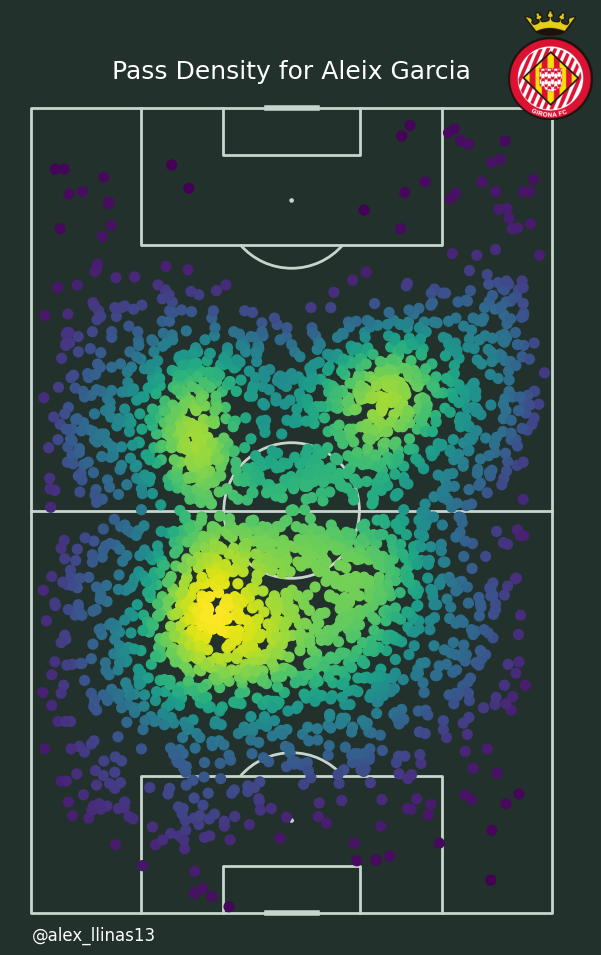

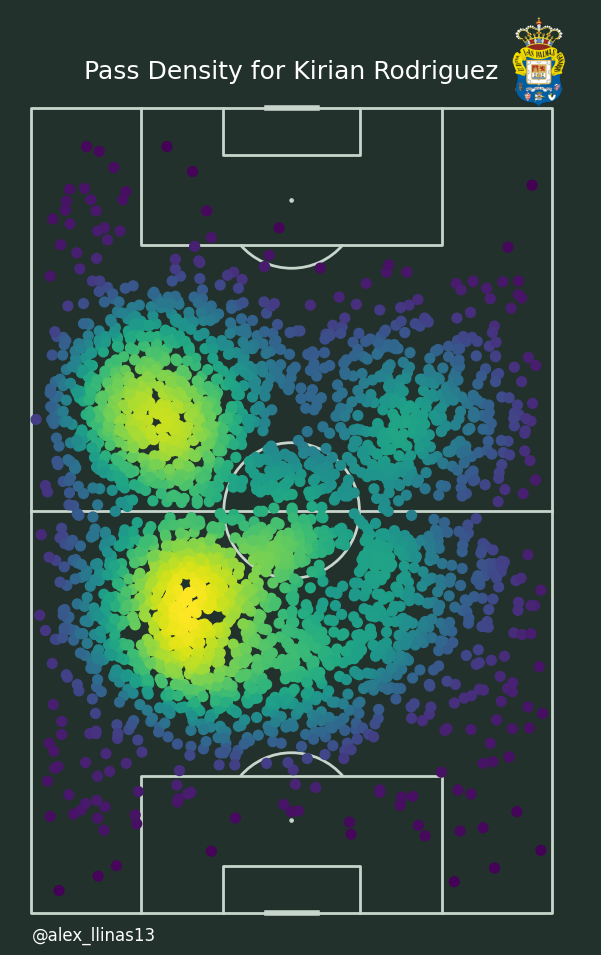

In [14]:
# density plots
plot_pass_density(aleix_passes, girona_logo)
plot_pass_density(kirian_passes, las_palmas_logo)

(<Figure size 1600x1100 with 2 Axes>,
 <Axes: title={'center': 'Passes by Kirian Rodriguez'}>)

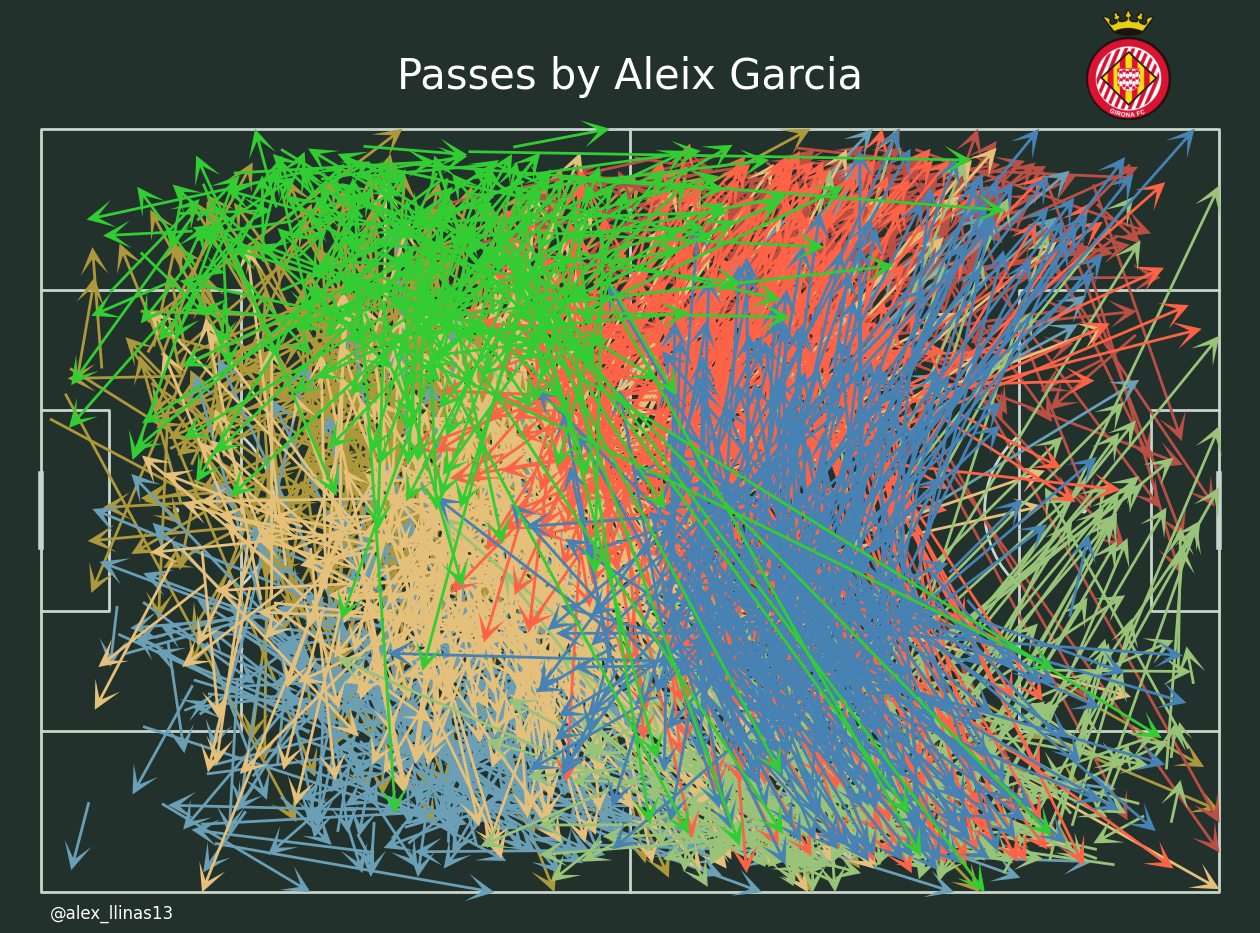

In [15]:
# cluster plots
plot_passes_by_cluster(aleix_passes, girona_logo,use_cluster_centers=False)
plot_passes_by_cluster(kirian_passes, las_palmas_logo, use_cluster_centers=False)

(<Figure size 1600x1100 with 2 Axes>,
 <Axes: title={'center': 'Passes by Kirian Rodriguez'}>)

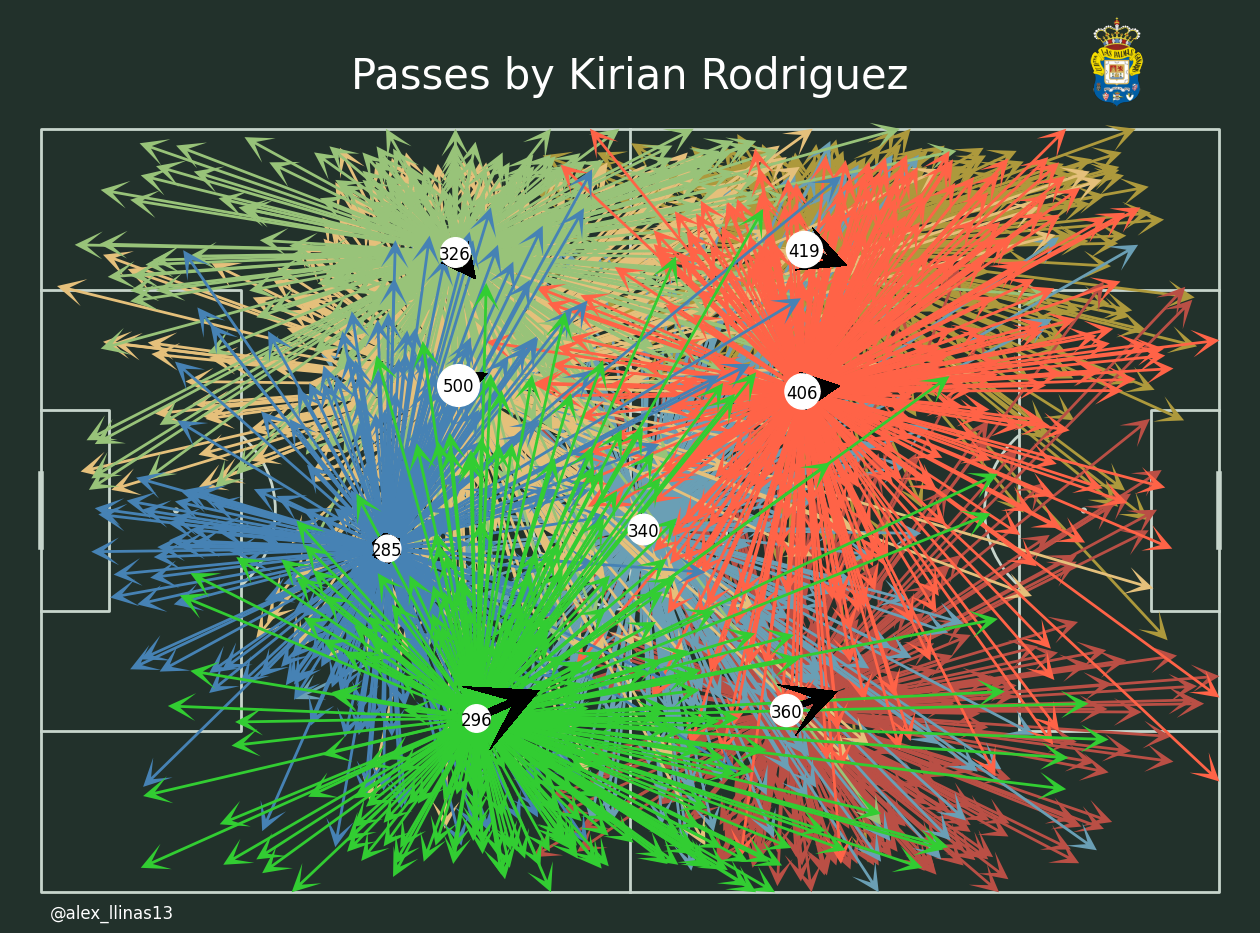

In [16]:
plot_passes_by_cluster(aleix_passes, girona_logo, use_cluster_centers=True, avg_end_points=True)
plot_passes_by_cluster(kirian_passes, las_palmas_logo, use_cluster_centers=True, avg_end_points=True)

### Aleix Garcia:

Pass Distribution and Volume:

- Aleix has a great distribution of passes in all the lanes of the field, both in his own half and in the opponent's.

- The clusters with the highest number of passes are in the centre of the field, which is typical for a central midfielder, as these players are usually the axis of distribution.

Average Pass Direction and Length:

- Passes from the centre of the field to the wing and between the wings are quite frequent and seem longer than those of Kirian.

- In the centre-right lane of the field in his own half (cluster 402), the passes are more vertical but shorter, suggesting that Aleix tends to drop back to progress the game with shorter passes in this area.

### Kirian Rodriguez:

Pass Distribution and Volume:

- Kirian also shows a wide distribution, but with a slight preference for participating in the clusters on the left side.

- In the opposition half, a greater number of passes are observed in the wide lanes.

- The placement of passes for the right central lane is significantly further back than Aleix's.

Average Pass Direction and Length:

- Except for clusters from the right lane, passes tend to be shorter than Aleix's.


### Playing Style:

Aleix Garcia appears to be a more dynamic central midfielder in terms of distribution, with a notable emphasis on switches of play and long passes, especially from the centre of the field to the wings. This is consistent with the statistical data above showing his higher number of long passes and switches of play.

Kirian Rodriguez, on the other hand, appears to play a more conservative role, with a focus on maintaining possession and distributing the ball from safer positions in his own half, with fewer long passes and more shorter, safe passes. He tends to operate more from the left side, both in his own field and in the opposite field, but when he moves to the right lane in attack, his passes become more deep and risky. This indicates a transition strategy, where he could be looking to exploit open spaces or connect with players in more advanced positions.

In this sense, Aleix can be key to opening up the game and changing the pace of attacks with his long passes, while Kirian could be more important for building play and keeping possession.

## Clustering Analysis

In [17]:
# labels for the clusters
print(aleix_cluster_centers)
aleix_passes.loc[:, 'cluster_label'] = aleix_passes['cluster'].map(
    {0: 'opp-right-center', 1: 'opp-left-wing', 2: 'own-right-center', 3: 'own-left-center',
     4: 'opp-left-center', 5: 'opp-right-wing', 6: 'own-left-wing', 7: 'own-right-wing'}
)
print(kirian_cluster_centers)
kirian_passes.loc[:, 'cluster_label'] = kirian_passes['cluster'].map(
    {0: 'opp-left-wing', 1: 'opp-right-center', 2: 'own-left-center', 3: 'own-right-center',
     4: 'opp-left-center', 5: 'own-left-wing', 6: 'opp-right-wing', 7: 'own-right-wing'}
)


[[62.21005435 37.33016304]
 [65.80625    83.52008929]
 [37.42704715 44.32655087]
 [29.19193154 63.69046455]
 [57.69311164 64.18598575]
 [67.91683502 15.56734007]
 [32.71700405 83.2562753 ]
 [33.18071895 23.58104575]]
[[64.77350835 84.26634845]
 [51.12147059 47.56823529]
 [35.43972056 66.48163673]
 [29.37754386 45.07192982]
 [64.6273399  65.65320197]
 [35.13742331 83.82177914]
 [63.25333333 23.86194444]
 [36.94813559 22.81661017]]


In [18]:
def calculate_proportions(df, passes_df, column_name, new_column_prefix):
    # calculate the number of passes in each cluster
    pass_count = passes_df[passes_df[column_name] == 1]['cluster_label'].value_counts().reset_index()
    pass_count.columns = ['cluster_label', f'{new_column_prefix}_count']
    
    # combine the dataframes
    df = pd.merge(df, pass_count, on='cluster_label', how='outer')
    
    # fill the NaN values with 0
    df.fillna(0, inplace=True)
    df[f'{new_column_prefix}_count'] = df[f'{new_column_prefix}_count'].astype(int)
    
    # calculate the proportion of passes in each cluster
    df[f'{new_column_prefix}_prop'] = df[f'{new_column_prefix}_count'] / pass_count[f'{new_column_prefix}_count'].sum()
    
    # drop the pass count columns
    df.drop(columns=[f'{new_column_prefix}_count'], inplace=True)
    
    return df

In [19]:
# List of variables to process
variables = [
    ('assist', 'aleix_assist', aleix_passes),
    ('assist', 'kirian_assist', kirian_passes),
    ('long_ball', 'aleix_long', aleix_passes),
    ('long_ball', 'kirian_long', kirian_passes),
    ('aerial', 'aleix_aerial', aleix_passes),
    ('aerial', 'kirian_aerial', kirian_passes),
    ('switch_of_play', 'aleix_switch_of_play', aleix_passes),
    ('switch_of_play', 'kirian_switch_of_play', kirian_passes),
    ('is_a_cross', 'aleix_cross', aleix_passes),
    ('is_a_cross', 'kirian_cross', kirian_passes),
    ('is_progressive', 'aleix_progressive', aleix_passes),
    ('is_progressive', 'kirian_progressive', kirian_passes),
    ('into_final_third', 'aleix_into_final_third', aleix_passes),
    ('into_final_third', 'kirian_into_final_third', kirian_passes)
]

# Initialize combined_df
combined_df = pd.DataFrame({'cluster_label': aleix_passes['cluster_label'].unique()})

# Process each variable
for column_name, new_column_prefix, passes_df in variables:
    combined_df = calculate_proportions(combined_df, passes_df, column_name, new_column_prefix)

# Add cluster centers to the combined_df
aleix_cluster_centers_df = aleix_passes[['cluster_center_x', 'cluster_center_y', 'cluster_label']].drop_duplicates()
kirian_cluster_centers_df = kirian_passes[['cluster_center_x', 'cluster_center_y', 'cluster_label']].drop_duplicates()

combined_df = pd.merge(combined_df, aleix_cluster_centers_df, on='cluster_label')
combined_df = pd.merge(combined_df, kirian_cluster_centers_df, on='cluster_label', suffixes=('_aleix', '_kirian'))

## CALCULATE SUCCESS RATES

# calculate the proportion of passes in each cluster
aleix_proportion = aleix_passes['cluster_label'].value_counts(normalize=True).reset_index()
aleix_proportion.columns = ['cluster_label', 'aleix_total_passes_prop']
kirian_proportion = kirian_passes['cluster_label'].value_counts(normalize=True).reset_index()
kirian_proportion.columns = ['cluster_label', 'kirian_total_passes_prop']

# calculate the number of successful passes in each cluster
aleix_success_count = aleix_passes[aleix_passes['outcome'] == 1]['cluster_label'].value_counts().reset_index()
aleix_success_count.columns = ['cluster_label', 'aleix_success_count']
kirian_success_count = kirian_passes[kirian_passes['outcome'] == 1]['cluster_label'].value_counts().reset_index()
kirian_success_count.columns = ['cluster_label', 'kirian_success_count']

# combine the two dataframes
combined_df = pd.merge(combined_df, kirian_proportion, on='cluster_label')
combined_df = pd.merge(combined_df, aleix_proportion, on='cluster_label')

combined_df = pd.merge(combined_df, aleix_success_count, on='cluster_label')
combined_df = pd.merge(combined_df, kirian_success_count, on='cluster_label')

# calculate the success rate for each cluster
combined_df['aleix_success_rate'] = combined_df['aleix_success_count'] / (combined_df['aleix_total_passes_prop'] * len(aleix_passes))
combined_df['kirian_success_rate'] = combined_df['kirian_success_count'] / (combined_df['kirian_total_passes_prop'] * len(kirian_passes))

# drop the success count columns
combined_df.drop(columns=['aleix_success_count', 'kirian_success_count'], inplace=True)

In [20]:
# Perform the z-test for each cluster
asterisks = []
for cluster in combined_df['cluster_label'].unique():
    aleix_count = aleix_passes[aleix_passes['cluster_label'] == cluster].shape[0]
    kirian_count = kirian_passes[kirian_passes['cluster_label'] == cluster].shape[0]
    
    aleix_total = aleix_passes.shape[0]
    kirian_total = kirian_passes.shape[0]
    
    aleix_prop = aleix_count / aleix_total
    kirian_prop = kirian_count / kirian_total
    
    count = [aleix_count, kirian_count]
    nobs = [aleix_total, kirian_total]
    
    z_stat, p_value = proportions_ztest(count, nobs)
    
    print(f"Cluster: {cluster}, Aleix proportion: {aleix_prop:.2f}, Kirian proportion: {kirian_prop:.2f}, Z-statistic: {z_stat:.2f}, P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        asterisks.append('*')
        print('The difference is statistically significant')
    else:
        asterisks.append('')
        print('The difference is not statistically significant')

Cluster: opp-left-center, Aleix proportion: 0.16, Kirian proportion: 0.14, Z-statistic: 2.03, P-value: 0.0420
The difference is statistically significant
Cluster: opp-left-wing, Aleix proportion: 0.08, Kirian proportion: 0.14, Z-statistic: -6.85, P-value: 0.0000
The difference is statistically significant
Cluster: opp-right-center, Aleix proportion: 0.14, Kirian proportion: 0.12, Z-statistic: 2.39, P-value: 0.0167
The difference is statistically significant
Cluster: opp-right-wing, Aleix proportion: 0.11, Kirian proportion: 0.12, Z-statistic: -1.32, P-value: 0.1860
The difference is not statistically significant
Cluster: own-left-center, Aleix proportion: 0.15, Kirian proportion: 0.17, Z-statistic: -1.87, P-value: 0.0619
The difference is not statistically significant
Cluster: own-left-wing, Aleix proportion: 0.09, Kirian proportion: 0.11, Z-statistic: -2.33, P-value: 0.0199
The difference is statistically significant
Cluster: own-right-center, Aleix proportion: 0.15, Kirian proportion

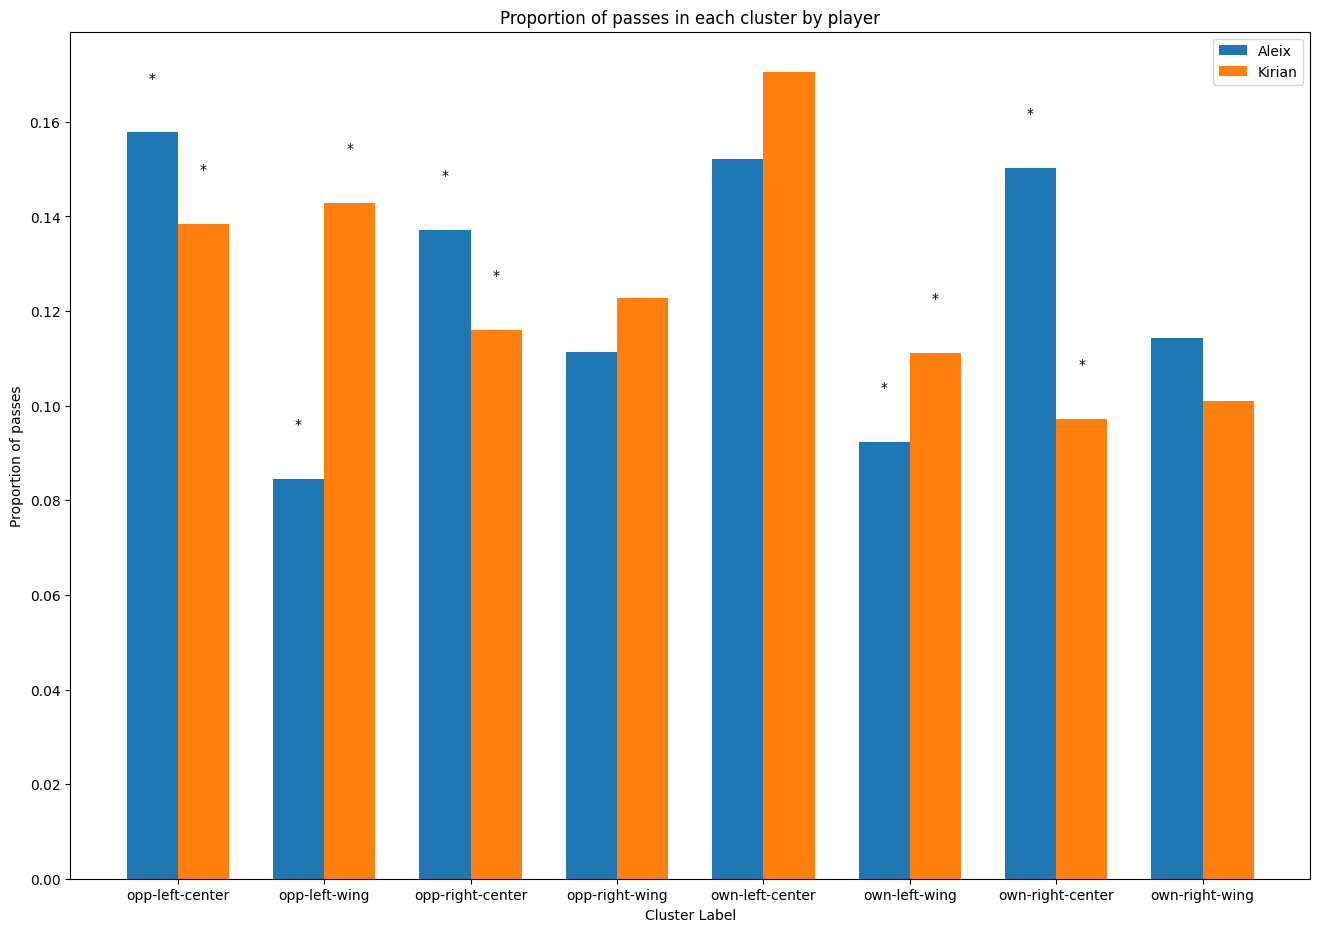

In [21]:
# plot the proportion of passes in each cluster
fig, ax = plt.subplots(figsize=(16, 11))
width = 0.35

# bar positions
x = combined_df['cluster_label']
x_indices = range(len(x))

# bar plot
bars_aleix = ax.bar(x_indices, combined_df['aleix_total_passes_prop'], width, label='Aleix')
bars_kirina = ax.bar([i + width for i in x_indices], combined_df['kirian_total_passes_prop'], width, label='Kirian')

# labels
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Proportion of passes')
ax.set_title('Proportion of passes in each cluster by player')
ax.set_xticks([i + width / 2 for i in x_indices])
ax.set_xticklabels(x)
ax.legend()

# add the asterisks
for i, bar in enumerate(bars_aleix):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, asterisks[i], ha='center', va='bottom')

for i, bar in enumerate(bars_kirina):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, asterisks[i], ha='center', va='bottom')

plt.show()


Significant Differences: Aleix Garcia has a higher proportion of passes in the opp-left-center, opp-right-center, and own-right-center zones, suggesting a greater influence in those areas, especially in the center-right of the field. Kirian Rodriguez, on the other hand, has a higher proportion in the opp-left-wing and own-left-wing zones, reflecting his tendency to operate more from the left flank, both in the opponent's and own half.

Non-Significant Differences: In the clusters where the differences are not significant (opp-right-wing, own-left-center, own-right-wing), both players appear to have a similar impact, which could indicate shared roles or team strategies that assign them similar responsibilities in these zones.

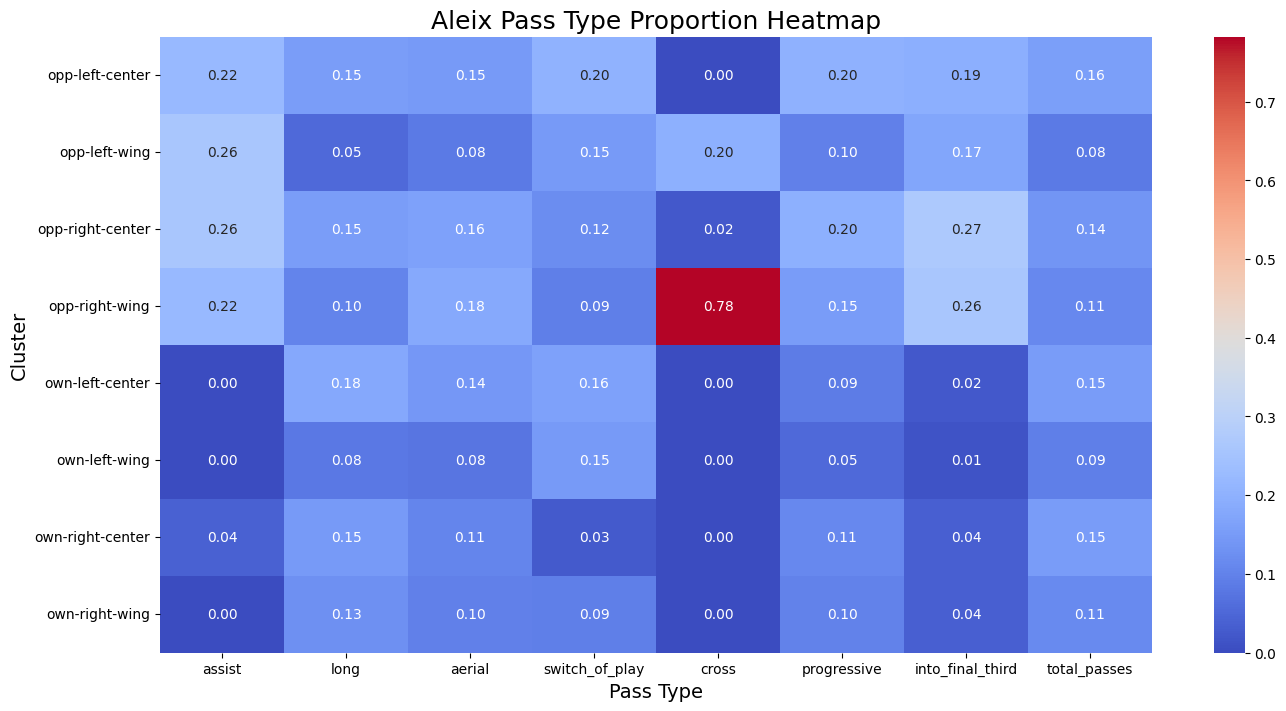

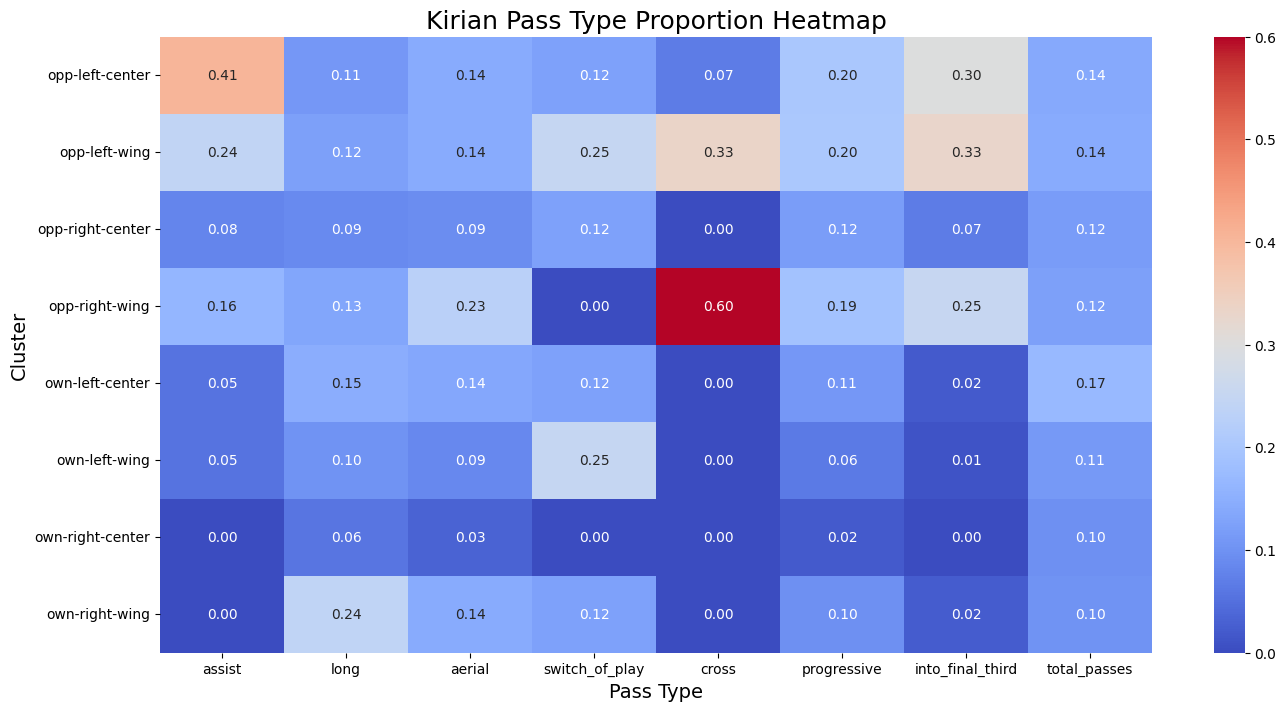

In [22]:
combined_df.set_index('cluster_label', inplace=True)
# Rename the columns for Aleix and Kirian
aleix_cols = ['aleix_assist_prop', 'aleix_long_prop', 'aleix_aerial_prop',
              'aleix_switch_of_play_prop', 'aleix_cross_prop', 'aleix_progressive_prop',
              'aleix_into_final_third_prop', 'aleix_total_passes_prop']
kirian_cols = ['kirian_assist_prop', 'kirian_long_prop', 'kirian_aerial_prop',
               'kirian_switch_of_play_prop', 'kirian_cross_prop', 'kirian_progressive_prop',
               'kirian_into_final_third_prop', 'kirian_total_passes_prop']

aleix_rename_dict = {col: col.replace('aleix_', '').replace('_prop', '') for col in aleix_cols}
kirian_rename_dict = {col: col.replace('kirian_', '').replace('_prop', '') for col in kirian_cols}

combined_df_aleix = combined_df[aleix_cols].rename(columns=aleix_rename_dict)
combined_df_kirian = combined_df[kirian_cols].rename(columns=kirian_rename_dict)

# heatmap for Aleix
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(combined_df_aleix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
ax.set_title('Aleix Pass Type Proportion Heatmap', fontsize=18)
ax.set_xlabel('Pass Type', fontsize=14)
ax.set_ylabel('Cluster', fontsize=14)
plt.xticks(rotation=0)
plt.show()

# heatmap for Kirian
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(combined_df_kirian, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
ax.set_title('Kirian Pass Type Proportion Heatmap', fontsize=18)
ax.set_xlabel('Pass Type', fontsize=14)
ax.set_ylabel('Cluster', fontsize=14)
plt.xticks(rotation=0)
plt.show()

### Aleix Garcia:

Right Wing in Opponent's Half:

- Cross: Aleix makes a high proportion of crosses (78%) from this position. This highlights his tendency to seek crosses when in this area, which is consistent with his more advanced and attacking role in this wing.
- Long Balls and Switch of Play: Although there is a low percentage of switches of play (9%) and long passes (10%), the focus here seems to be clearly on crosses.

Right Wing in Opponent's Half:

- Progressive and Into Final Third: Here we see a significant proportion of progressive passes (27%) and passes that advance the ball into the final third (14%), indicating that Aleix also uses this position to advance play.

Left Wing in Own Half:

- Long Balls: There is a relevant percentage of long passes (18% and 8%) from these areas, which suggests that from his own half, Aleix Garcia tends to look for safer options or switches of play.

Central Lanes:

- Distribution: From these positions, his distribution of pass types is more balanced, with some leaning towards long, progressive passes, but less emphasis on crosses or switches of play.

### Kirian Rodriguez:

Left Lane in Opposition:

- Assist and Progressive: Kirian has a high proportion of assists (41%) and progressive passes (25%) from these areas. This suggests that he is more likely to play creatively and look for scoring opportunities from the left wing in the opposition half.

- Cross: A decent percentage of his passes from the left wing in the opposition half are also crosses (33%), although less than Aleix on the right wing.

Right Lane in Opposition

- Cross and Switch of Play: Similar to Aleix, Kirian also makes a high proportion of crosses (60%) from this area, along with a considerable number of switches of play (23%).

Central Lane in Own Half:

- Long Balls: From the centre of the pitch in his own half, Kirian makes a significant amount of long passes (15% and 6%), but these are less prevalent than Aleix, suggesting a more conservative distribution.

### Roles and Areas of Influence:

Aleix Garcia: His role on the pitch seems to be very focused on being a versatile distributor, capable of making a large number of crosses from the right wing in the opposition half. He also excels at progressive passes from central areas.

Kirian Rodriguez: He tends to be more creative and dangerous from the left wing, with a high proportion of assists and progressive passes. On the right wing in the opposition half, his game becomes more similar to Aleix's, with a high frequency of crosses and switches of play.

Overall Comparison:

Aleix seems to be more balanced in his distribution of pass types, while Kirian has specific areas where certain types of passes clearly dominate, such as on the left wing in the opposition half for assists and on the right wing for crosses.

## Conclusions

This comparative analysis reveals that, although Aleix Garcia and Kirian Rodriguez share the characteristic of being influential midfielders with a high amount of passing, their playing styles and impact zones on the pitch are different:

Aleix Garcia is a more versatile and balanced player in terms of distribution, with a preference for deep and more direct distribution of his passes.

Kirian Rodriguez is distinguished by his influence on the left flank, where he makes most of his assists and progressive passes. In addition, his tendency to make long passes from the right in his own half suggests a strategic focus on quick transitions.